In [142]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
import pathlib
import math
import plotly.express as px
import plotly.graph_objects as go

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

In [21]:
# Set path to target data from WHO weekly time series
target_data_path = pathlib.Path('../data/target-data/case-data.csv')

In [22]:
# Load in target data from WHO weekly time series
data = pd.read_csv(target_data_path, index_col=0)
data.index = pd.to_datetime(data.index)

In [23]:
# Also load daily time series data from owid
mys_data_daily = pd.read_csv("https://github.com/monash-emu/wpro_working/raw/main/data/new_cases.csv", index_col=0)["MYS"]
mys_data_daily.index = pd.to_datetime(mys_data_daily.index)

In [ ]:
mys_data_daily.plot()

In [ ]:
data['New_cases_MYS'].plot()

In [139]:
data

,New_cases_MYS,Cumulative_cases_MYS,New_case_PHL,Cumulative_cases_PHL,New_case_VNM,Cumulative_cases_VNM
Date_reported,,,,,,
2020-01-05,0.0,0,0.0,0,0.0,0
2020-01-12,0.0,0,0.0,0,0.0,0
2020-01-19,0.0,0,0.0,0,0.0,0
2020-01-26,4.0,4,0.0,0,2.0,2
2020-02-02,4.0,8,1.0,1,4.0,6
...,...,...,...,...,...,...
2024-03-17,593.0,5277473,0.0,4140383,0.0,11624000
2024-03-24,512.0,5277985,0.0,4140383,0.0,11624000
2024-03-31,421.0,5278406,0.0,4140383,0.0,11624000


In [24]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
mys_data = data['New_cases_MYS']
pop = 33e6
analysis_start = datetime(2021, 3, 1)
analysis_end = datetime(2021, 11, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = mys_data.loc[analysis_start: analysis_end]
init_data = mys_data.loc[init_start: init_end]

In [25]:
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(33e6, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), 50, init_data, GammaDens())

C:\Users\ehug0006\Miniconda3\envs\renewal-wpr\lib\site-packages\emu_renewal\renew.py:59: UserWarning:

Padding initialisation series with zeroes because shorter than window



In [26]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(5.0, 0.4, low=0.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=0.0),
    "cdr": dist.Beta(4.0, 10.0),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(5, 0.5, low=0.0),
    "report_sd": dist.TruncatedNormal(2, 0.5, low=0.0),
}

In [27]:
calib = StandardCalib(renew_model, priors, select_data, indicator='weekly_sum')
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=1000, num_warmup=1000)
mcmc.run(random.PRNGKey(1))

Running chain 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:24<00:00, 23.68it/s]


In [28]:
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=200)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

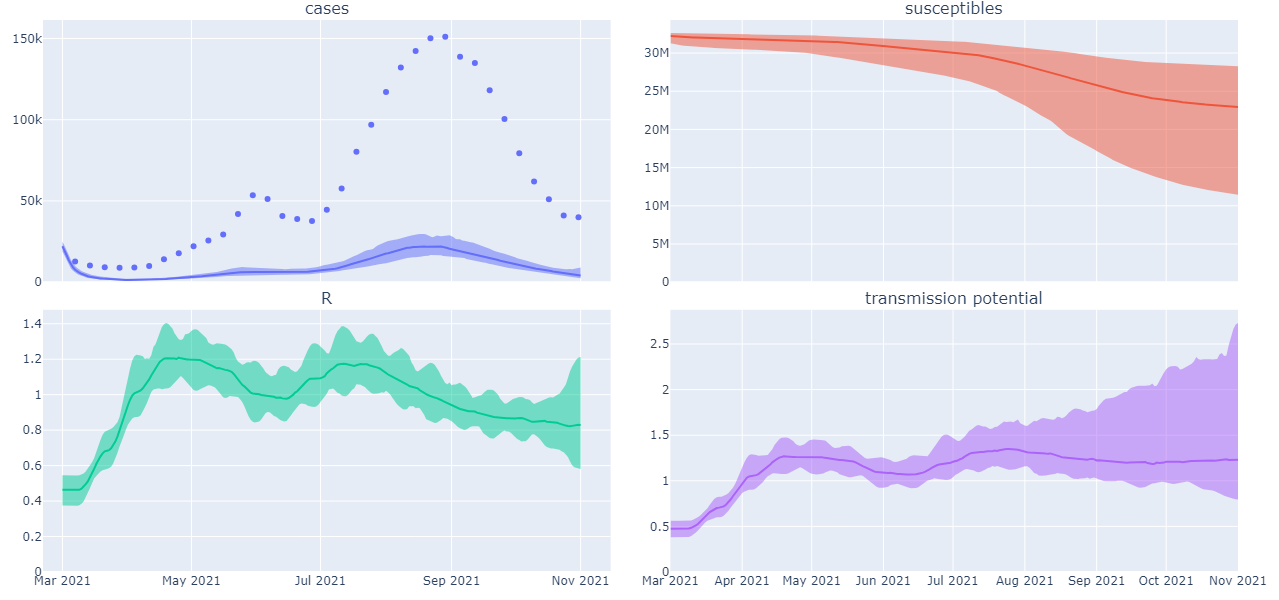

In [29]:
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95])
plot_uncertainty_patches(quantiles_df, select_data, qual_colours.Plotly).update_layout(showlegend=False)

In [ ]:
az.summary(idata)

In [ ]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);

In [114]:
model_daily_cases = quantiles_df['cases'][0.50]

In [115]:
model_daily_cases = pd.DataFrame(model_daily_cases)

In [116]:
# create date column and reset index

model_daily_cases = model_daily_cases.reset_index()
model_daily_cases = model_daily_cases.rename(columns={"index": "date"})

In [ ]:
# create week identifer
model_daily_cases['weekofyear']=pd.to_datetime(model_daily_cases['date']).dt.strftime('%U')
#create year identifier
model_daily_cases['year']=pd.to_datetime(model_daily_cases['date']).dt.strftime('%Y')

In [123]:
model_daily_cases

,date,0.5,weekofyear,year
0,2021-03-01,22146.514825,09,2021
1,2021-03-02,19634.770303,09,2021
2,2021-03-03,16586.032985,09,2021
3,2021-03-04,13534.305455,09,2021
4,2021-03-05,10950.957003,09,2021
...,...,...,...,...
241,2021-10-28,4930.418789,43,2021
242,2021-10-29,4780.321782,43,2021
243,2021-10-30,4538.760587,43,2021
244,2021-10-31,4356.104555,44,2021


In [126]:

#calculate sum of values, grouped by week
weekly_cases = model_daily_cases.groupby(['weekofyear','year'])[0.5].sum()

In [132]:
weekly_cases = weekly_cases.reset_index()

In [135]:
weekly_cases

,weekofyear,year,0.5,weekDate
0,09,2021,91921.627199,2021-03-01
1,10,2021,37443.930171,2021-03-08
2,11,2021,18884.195692,2021-03-15
3,12,2021,12671.92247,2021-03-22
4,13,2021,9849.165319,2021-03-29
5,14,2021,10244.755887,2021-04-05
6,15,2021,11818.034752,2021-04-12
7,16,2021,15342.277068,2021-04-19
8,17,2021,20189.841338,2021-04-26
9,18,2021,25401.26441,2021-05-03


In [134]:
weekly_cases['weekDate'] = pd.to_datetime(
               weekly_cases['year'].astype(str)+'-'+weekly_cases['weekofyear'].astype(str)+'-1',
               format='%Y-%W-%w')         

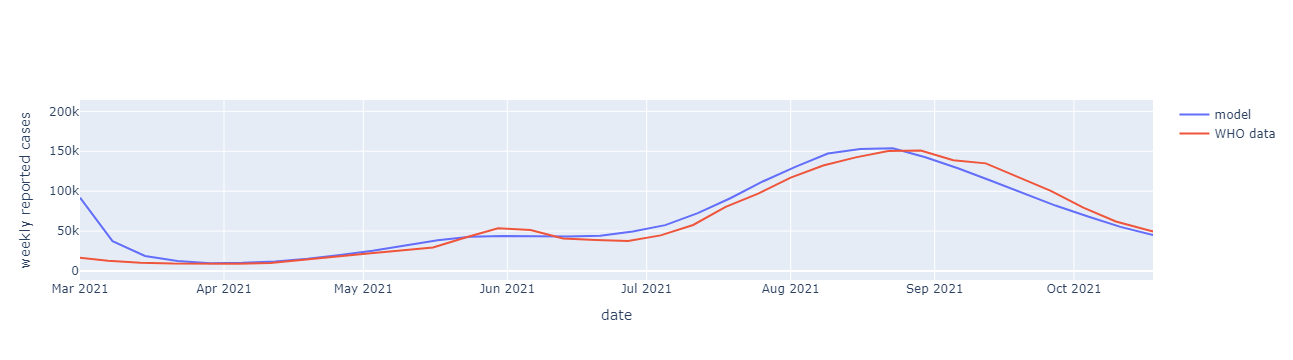

In [153]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=weekly_cases['weekDate'], y=weekly_cases[0.5],  name='model'))
              
fig.add_trace(go.Scatter(x=data.index, y=data['New_cases_MYS'], name='WHO data'))

fig.update_xaxes(range=(datetime(2021, 3, 1), datetime(2021, 10, 18)), title='date')
fig.update_yaxes(title='weekly reported cases')

fig.show()